In [35]:
import os
import shutil
import torch
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.optim import Adam

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler

from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

from utils.utils import oversample_category, mask_images, split_data

In [10]:
# Path to dataset
dataset_path = './Dataset_BUSI'

# List of subdirectories (categories)
categories = ['benign', 'malignant', 'normal']

In [11]:
# Count the number of images in each category and display
categories_size = []
for category in categories:
    path = os.path.join(dataset_path, category)
    images = os.listdir(path)
    categories_size.append(len(images))
    print(f"Number of {category} images:", len(images))

Number of benign images: 437
Number of malignant images: 210
Number of normal images: 133


In [6]:
img_dir = os.path.join(dataset_path, categories[1])
for filename in os.listdir(img_dir):
        # Check if the file is a PNG and ends with '_mask/1/2/.png'
    if (filename.endswith("_mask.png") or filename.endswith("_mask_1.png") or filename.endswith("_mask_2.png")) and filename.endswith(".png"):
        # Construct the full file path
        file_path = os.path.join(img_dir, filename)
        # Delete the file
        os.remove(file_path)

In [7]:
# Define paths
base_dir = './dataset_split'
os.makedirs(base_dir, exist_ok=True)

# Directories for the split dataset
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create train, validation, and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [8]:
# Split and copy files for each category
split_data('normal', dataset_path, train_dir, validation_dir, test_dir)
split_data('benign', dataset_path, train_dir, validation_dir, test_dir)
split_data('malignant', dataset_path, train_dir, validation_dir, test_dir)

In [12]:
# Transformations with augmentation for the training set
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Transformations for validation/test set
val_test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [13]:
train_dataset = datasets.ImageFolder(root=f'{base_dir}/train', transform=train_transforms)
test_dataset = datasets.ImageFolder(root=f'{base_dir}/test', transform=val_test_transforms)
val_dataset = datasets.ImageFolder(root=f'{base_dir}/val', transform=val_test_transforms)

In [15]:
# Calculate weights for all samples
class_weights = []
for root, subdir, files in os.walk(f'{base_dir}/train'):
    if len(files) > 0:
        class_weights.append(1.0 / len(files))

sample_weights = [0] * len(train_dataset)
for idx, (data, label) in enumerate(train_dataset.imgs):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight
print(class_weights)

[0.007936507936507936, 0.0038314176245210726, 0.012658227848101266]


In [16]:
# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Create the DataLoader for train dataset with the sampler
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)

# For test and validation sets
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [43]:
def show_images(images, labels, classes):
    images = images / 2 + 0.5 
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(images[:16]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

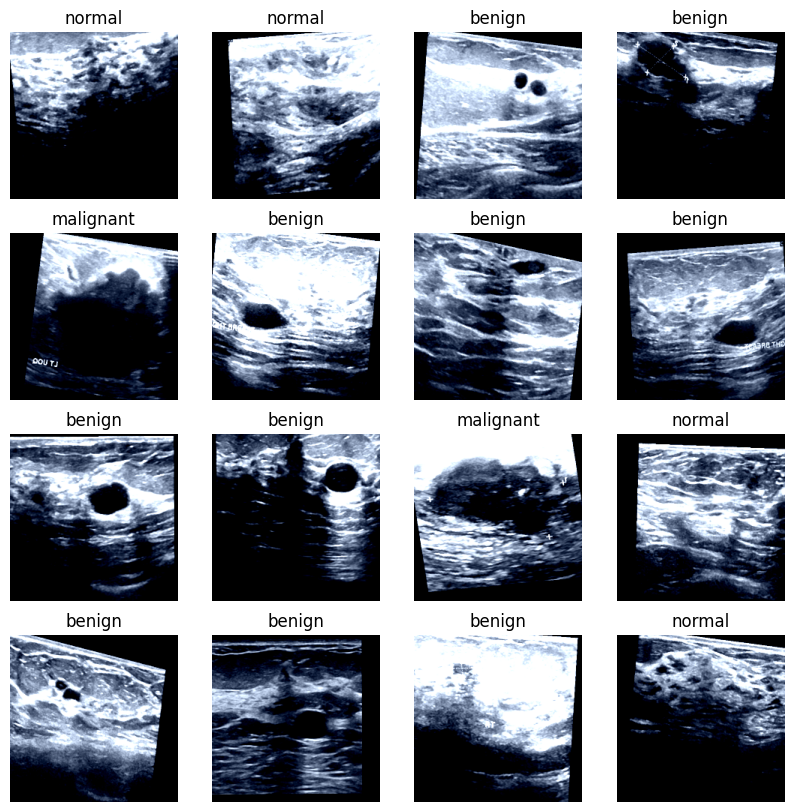

In [44]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

show_images(images, labels, categories)

In [23]:
class CustomMobileNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomMobileNet, self).__init__()
        # Load a pre-trained MobileNetV2 model
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        # Replace the classifier layer
        self.mobilenet.classifier[1] = nn.Linear(self.mobilenet.last_channel, num_classes)

        # Freeze all layers
        for param in self.mobilenet.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Replicate grayscale input to 3 channels
        if x.size(1) == 1:
            x = x.repeat(1, 3, 1, 1)
        return self.mobilenet(x)

In [28]:
# Initialize the model
num_classes = 3
model = CustomMobileNet(num_classes=num_classes)

# Unfreeze the last N layers
N = 20
child_counter = 0
for child in model.mobilenet.features.children():
    if child_counter >= len(list(model.mobilenet.features.children())) - N:
        for param in child.parameters():
            param.requires_grad = True
    child_counter += 1

# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00005)

In [29]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))

In [30]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training and validation loop
epochs = 10 
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    validate(model, device, val_loader)

validate(model, device, test_loader)

Train Epoch: 1 [0/466 (0%)]	Loss: 1.245886
Train Epoch: 1 [320/466 (67%)]	Loss: 0.878383

Validation set: Average loss: 0.9595, Accuracy: 95/157 (61%)

Train Epoch: 2 [0/466 (0%)]	Loss: 0.807259
Train Epoch: 2 [320/466 (67%)]	Loss: 0.626611

Validation set: Average loss: 0.8120, Accuracy: 101/157 (64%)

Train Epoch: 3 [0/466 (0%)]	Loss: 0.463710
Train Epoch: 3 [320/466 (67%)]	Loss: 0.582649

Validation set: Average loss: 0.6897, Accuracy: 109/157 (69%)

Train Epoch: 4 [0/466 (0%)]	Loss: 0.498286
Train Epoch: 4 [320/466 (67%)]	Loss: 0.533712

Validation set: Average loss: 0.6413, Accuracy: 111/157 (71%)

Train Epoch: 5 [0/466 (0%)]	Loss: 0.413628
Train Epoch: 5 [320/466 (67%)]	Loss: 0.352356

Validation set: Average loss: 0.5641, Accuracy: 121/157 (77%)

Train Epoch: 6 [0/466 (0%)]	Loss: 0.304294
Train Epoch: 6 [320/466 (67%)]	Loss: 0.263365

Validation set: Average loss: 0.5327, Accuracy: 122/157 (78%)

Train Epoch: 7 [0/466 (0%)]	Loss: 0.337325
Train Epoch: 7 [320/466 (67%)]	Loss: 0.2

In [31]:
model.eval()

true_labels_test = []
pred_labels_test = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=False)
        true_labels_test.extend(target.cpu().numpy())
        pred_labels_test.extend(pred.cpu().numpy())  

In [33]:
# Calculate the confusion matrix
conf_mat_test = confusion_matrix(true_labels_test, pred_labels_test)
print("Confusion Matrix on Test Set:\n", conf_mat_test)

# Calculate accuracy, precision, recall, and F1-score
accuracy_test = accuracy_score(true_labels_test, pred_labels_test)
precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(true_labels_test, pred_labels_test, average='macro')

print(f"Accuracy on Test Set: {accuracy_test}")
print(f"Precision on Test Set: {precision_test}")
print(f"Recall on Test Set: {recall_test}")
print(f"F1 Score on Test Set: {f1_test}")

Confusion Matrix on Test Set:
 [[75  8  5]
 [ 9 33  0]
 [ 1  2 24]]
Accuracy on Test Set: 0.8407643312101911
Precision on Test Set: 0.8257936695127128
Recall on Test Set: 0.8422919672919673
F1 Score on Test Set: 0.8335551561665128


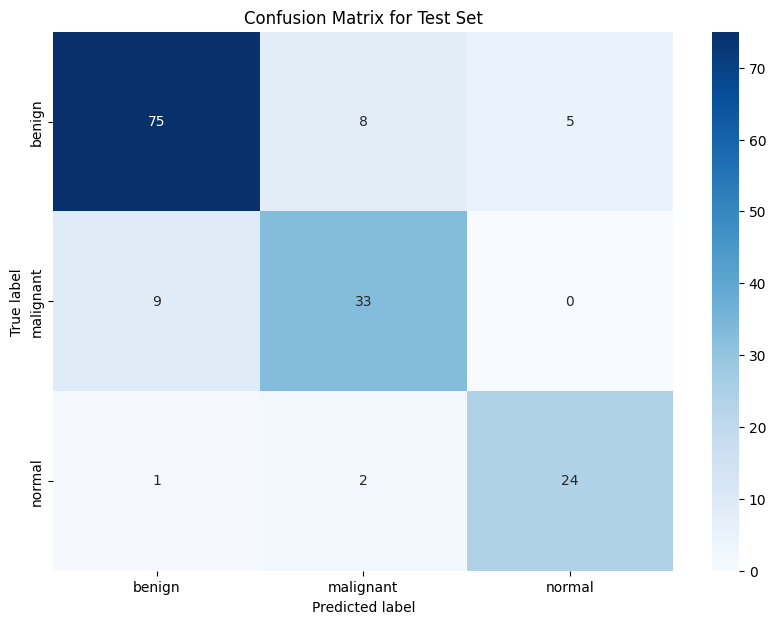

In [36]:
# Assuming class names are defined as class_names
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat_test, annot=True, fmt="d", cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix for Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [37]:
# Calculate metrics for each class
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
    true_labels_test, pred_labels_test, average=None)

# Calculate overall accuracy by comparing the true and predicted labels
accuracy_overall = accuracy_score(true_labels_test, pred_labels_test)

print(f"Overall Accuracy: {accuracy_overall}")
print(f"Precision per Class: {precision_per_class}")
print(f"Recall per Class: {recall_per_class}")
print(f"F1 Score per Class: {f1_per_class}")

Overall Accuracy: 0.8407643312101911
Precision per Class: [0.88235294 0.76744186 0.82758621]
Recall per Class: [0.85227273 0.78571429 0.88888889]
F1 Score per Class: [0.86705202 0.77647059 0.85714286]


In [38]:
for i, class_name in enumerate(categories):
    print(f"{class_name}: Precision: {precision_per_class[i]:.4f}, "
          f"Recall: {recall_per_class[i]:.4f}, F1: {f1_per_class[i]:.4f}")

benign: Precision: 0.8824, Recall: 0.8523, F1: 0.8671
malignant: Precision: 0.7674, Recall: 0.7857, F1: 0.7765
normal: Precision: 0.8276, Recall: 0.8889, F1: 0.8571
